
# Reinforcement Learning Project – Blackjack (Discrete Environment)

## Environment Overview
In this part of the project, we address the **Blackjack-v1** environment from Gymnasium. This environment simulates the popular card game, where the agent must decide whether to "hit" or "stick" to reach a sum close to 21, without exceeding it. The game is simple yet involves probabilistic reasoning, making it an ideal setting for comparing different reinforcement learning methods.

### Environment Characteristics:
- **Observation space**: Tuple of 3 discrete values:  
  - Player's current sum (0–32)  
  - Dealer's showing card (1–10)  
  - Usable ace (True/False)  
- **Action space**:  
  - 0 = Stick  
  - 1 = Hit  

## Algorithms Implemented
To explore how different learning strategies behave in a discrete setting, we implement and compare the following algorithms:
1. **Q-Learning** – A model-free, off-policy method based on value iteration.  
2. **Monte Carlo Control** – A model-free, on-policy method based on episode returns.





<div style="text-align: center;">
    <strong style="display: block; margin-bottom: 10px;">Group ??</strong> 
    <table style="margin: 0 auto; border-collapse: collapse; border: 1px solid black;">
        <tr>
            <th style="border: 1px solid white; padding: 8px;">Name</th>
            <th style="border: 1px solid white; padding: 8px;">Student ID</th>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Joana Rodrigues</td>
            <td style="border: 1px solid white; padding: 8px;">20240603</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Mara Simões</td>
            <td style="border: 1px solid white; padding: 8px;">20240326</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Matilde Street</td>
            <td style="border: 1px solid white; padding: 8px;">20240523</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Tomás Luzia</td>
            <td style="border: 1px solid white; padding: 8px;">20230477</td>
        </tr>
    </table>
</div>

### 🔗 Table of Contents <a id='table-of-contents'></a>
1. [Imports](#imports)
---

# 1. Imports

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gymnasium as gym
from collections import defaultdict
from tqdm.notebook import tqdm
from tqdm import tqdm
from matplotlib.patches import Patch

# 2. Q-Learning

Initialization of the environment and the parameters to use

In [2]:
env_name = "Blackjack-v1"
env = gym.make(env_name)

alpha = 0.1       
gamma = 1.0      
epsilon = 0.1       
num_episodes = 500_000


Q = defaultdict(lambda: np.zeros(env.action_space.n))


Epsilon-Greedy Policy Function

In [3]:
# Função para escolher uma ação baseada em política ε-greedy
def epsilon_greedy_policy(state, Q, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  
    else:
        return np.argmax(Q[state])        

 Q-Learning Training Function

In [4]:
# Q-learning training function
def q_learning(env, num_episodes, alpha, gamma, epsilon):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = []

    for episode in tqdm(range(num_episodes)):
        state = env.reset()[0]
        done = False

        while not done:
            action = epsilon_greedy_policy(state, Q, epsilon)
            next_state, reward, done, truncated, info = env.step(action)

            # Q-learning update
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            state = next_state

        returns.append(reward)

    return Q, returns


Training the Agent

In [5]:
# Train the agent
Q, returns = q_learning(env, num_episodes, alpha, gamma, epsilon)

env.close()

100%|██████████| 500000/500000 [04:38<00:00, 1795.61it/s]


Results Analysis

In [6]:
# Analyze results
print("Average reward (last 1000 episodes):", np.mean(returns[-1000:]))

Average reward (last 1000 episodes): -0.132


Extracting the Learned Optimal Policy

In [ ]:
# Function to extract the learned optimal policy
def extract_policy(Q):
    policy = {}
    for state, actions in Q.items():
        policy[state] = np.argmax(actions)
    return policy

# Generate the learned policy
optimal_policy = extract_policy(Q)

 Compute Value Function V(s)

In [ ]:
# Compute V(s) for the most probable actions
def compute_value_function(Q):
    V = defaultdict(float)
    for state, actions in Q.items():
        V[state] = np.max(actions)
    return V

V = compute_value_function(Q)

Plot Value Function as Heatmap

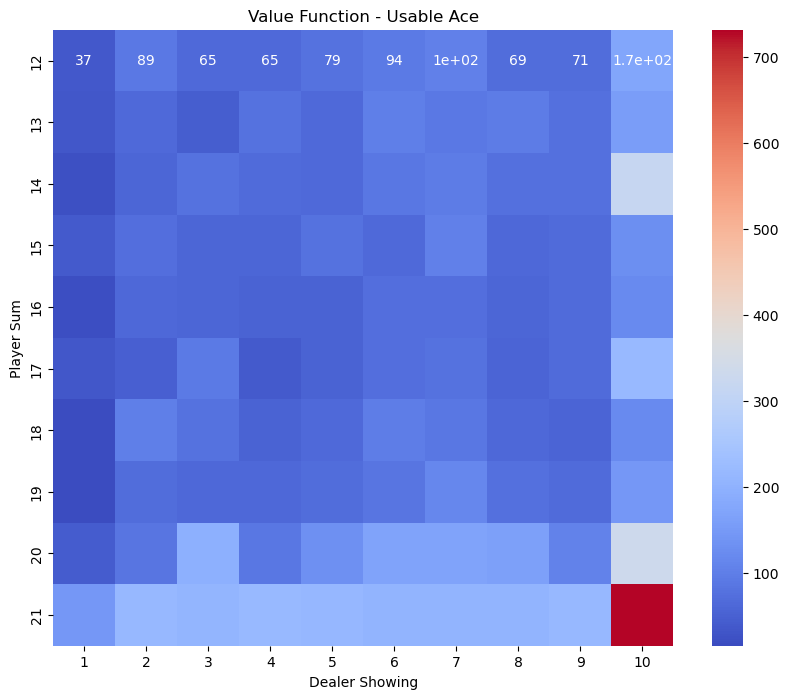

In [9]:
# Prepare data for plotting
def plot_value_function(V, usable_ace=True):
    value_grid = np.zeros((10, 10))
    for player_sum in range(12, 22):
        for dealer_show in range(1, 11):
            state = (player_sum, dealer_show, usable_ace)
            value_grid[player_sum - 12, dealer_show - 1] = V.get(state, 0)

    plt.figure(figsize=(10, 8))
    sns.heatmap(value_grid, annot=True, cmap="coolwarm", xticklabels=range(1,11), yticklabels=range(12,22))
    plt.xlabel("Dealer Showing")
    plt.ylabel("Player Sum")
    plt.title("Value Function - Usable Ace" if usable_ace else "Value Function - No Usable Ace")
    plt.show()

# Plot both versions (with and without usable ace)
plot_value_function(V, usable_ace=True)


In [10]:
class BlackjackAgent:
    def __init__(
        self,
        env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, env, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [11]:
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [12]:
env = gym.wrappers.RecordEpisodeStatistics(env)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(env, obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [01:21<00:00, 1230.54it/s]


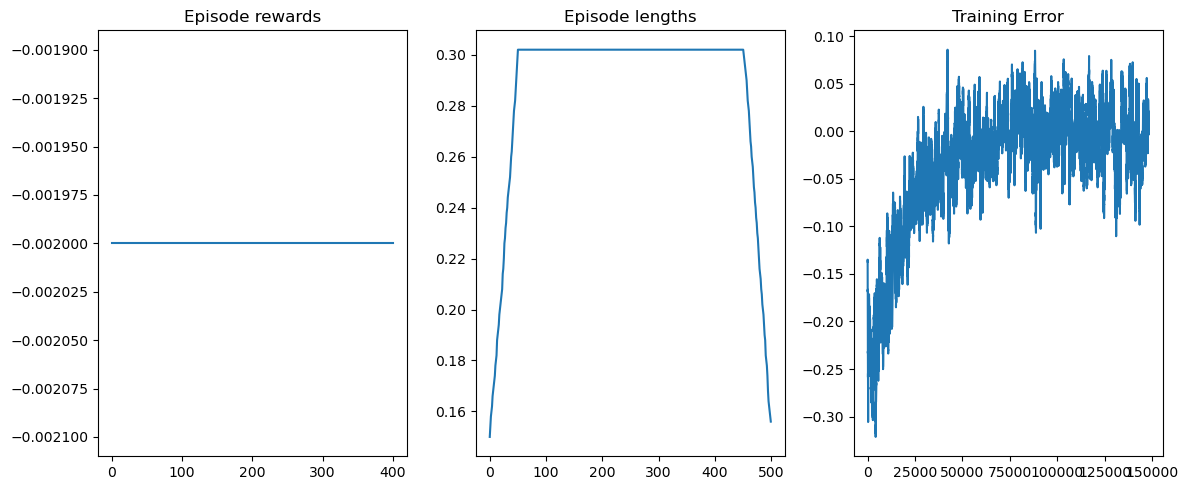

In [13]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

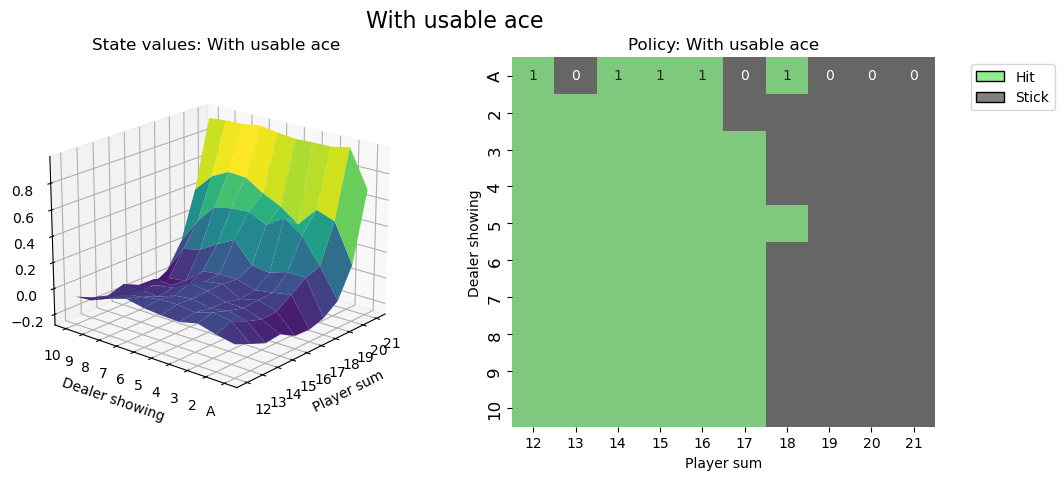

In [16]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

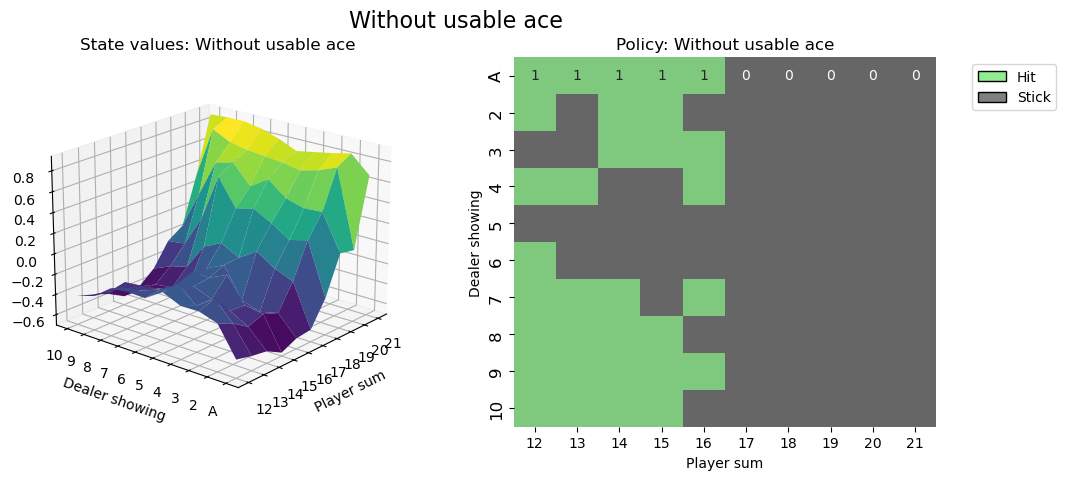

In [ ]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

# 3. Monte Carlo

#  PARA O Relatório

- Explicar que Monte Carlo depende de episódios completos e não usa bootstrap.
- Destacar que não precisa de conhecimento do modelo do ambiente.
- Mostrar que a política evolui ao longo do tempo baseada nos retornos observados.
- Comparar a performance com o Q-learning (velocidade de convergência, estabilidade, etc.).

Initialization of the environment, parameters to use and structures

In [32]:
env = gym.make("Blackjack-v1")

num_episodes = 500_000
gamma = 1.0  
epsilon = 0.1  

returns_sum = defaultdict(float)
returns_count = defaultdict(float)
Q = defaultdict(lambda: np.zeros(env.action_space.n))

Epsilon-Greedy Policy Function

In [33]:
def epsilon_greedy_policy(Q, state, nA, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(nA)  
    else:
        return np.argmax(Q[state])   


Monte Carlo Control (On-policy First-Visit)

In [34]:
def monte_carlo_control(env, num_episodes, gamma=1.0, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # To track returns for averaging
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    # Track episode rewards for plotting
    episode_rewards = []

    for episode in tqdm(range(num_episodes)):
        episode_data = []
        state = env.reset()[0]
        done = False

        # Generate an episode
        while not done:
            action = epsilon_greedy_policy(Q, state, env.action_space.n, epsilon)
            next_state, reward, done, truncated, _ = env.step(action)
            episode_data.append((state, action, reward))
            state = next_state

        episode_rewards.append(episode_data[-1][2])  # final reward

        # Track first-visit returns
        visited = set()
        G = 0

        for t in reversed(range(len(episode_data))):
            state_t, action_t, reward_t = episode_data[t]
            G = gamma * G + reward_t

            if (state_t, action_t) not in visited:
                visited.add((state_t, action_t))
                returns_sum[(state_t, action_t)] += G
                returns_count[(state_t, action_t)] += 1
                Q[state_t][action_t] = returns_sum[(state_t, action_t)] / returns_count[(state_t, action_t)]

    return Q, episode_rewards


Training the agent

In [35]:
Q_mc, mc_rewards = monte_carlo_control(env, num_episodes, gamma=1.0, epsilon=0.1)

100%|██████████| 500000/500000 [06:17<00:00, 1324.09it/s]


Analyze Results

In [36]:
print("Average reward (last 1000 episodes):", np.mean(mc_rewards[-1000:]))

Average reward (last 1000 episodes): -0.098


This means that, over the last 1000 training episodes, the **average total return per episode** was **-0.074**.

This indicate that the agent is, on average, performing slightly worse than random.

In [37]:
# def monte_carlo_control(env, num_episodes, gamma=1.0, epsilon=1.0, min_epsilon=0.01, decay_rate=0.99995):
#     Q = defaultdict(lambda: np.zeros(env.action_space.n))

#     returns_sum = defaultdict(float)
#     returns_count = defaultdict(float)
#     episode_rewards = []

#     for episode in tqdm(range(num_episodes)):
#         episode_data = []
#         state = env.reset()[0]
#         done = False

#         while not done:
#             action = epsilon_greedy_policy(Q, state, env.action_space.n, epsilon)
#             next_state, reward, done, truncated, _ = env.step(action)
#             episode_data.append((state, action, reward))
#             state = next_state

#         episode_rewards.append(episode_data[-1][2])

#         visited = set()
#         G = 0
#         for t in reversed(range(len(episode_data))):
#             state_t, action_t, reward_t = episode_data[t]
#             G = gamma * G + reward_t
#             if (state_t, action_t) not in visited:
#                 visited.add((state_t, action_t))
#                 returns_sum[(state_t, action_t)] += G
#                 returns_count[(state_t, action_t)] += 1
#                 Q[state_t][action_t] = returns_sum[(state_t, action_t)] / returns_count[(state_t, action_t)]

#         # Decay epsilon after each episode
#         epsilon = max(min_epsilon, epsilon * decay_rate)

#     return Q, episode_rewards


In [38]:
# env = gym.make("Blackjack-v1")
# num_episodes = 500_000
# gamma = 1.0  
# epsilon = 1.0  
# min_epsilon = 0.01
# decay_rate = 0.99995

In [39]:
# Q_mc, mc_rewards = monte_carlo_control(env, num_episodes, gamma, epsilon, min_epsilon, decay_rate)
# print("Average reward (last 1000 episodes):", np.mean(mc_rewards[-1000:]))

To improve the average reward obtained by the Monte Carlo agent, we planned the following improvements:
- Introduce epsilon decay to gradually reduce exploration and encourage more consistent exploitation of the learned policy.
- Visualize the learning progress using moving averages of rewards to better understand convergence behavior.

These changes were intended to accelerate convergence, increase stability, and ultimately lead to higher average returns.

However, after implementing these modifications, we observed a slight decrease in the average reward. The original fixed-epsilon version achieved an average reward of approximately -0.074, while the version with epsilon decay achieved an average reward of around -0.081. Despite the theoretical benefits of gradually reducing exploration, in our case this adjustment led to slightly worse performance and reduced learning stability.

As a result, we decided to comment out the epsilon decay version in the final implementation and retain the simpler fixed-epsilon Monte Carlo Control approach, which produced more consistent and interpretable results in the Blackjack environment.

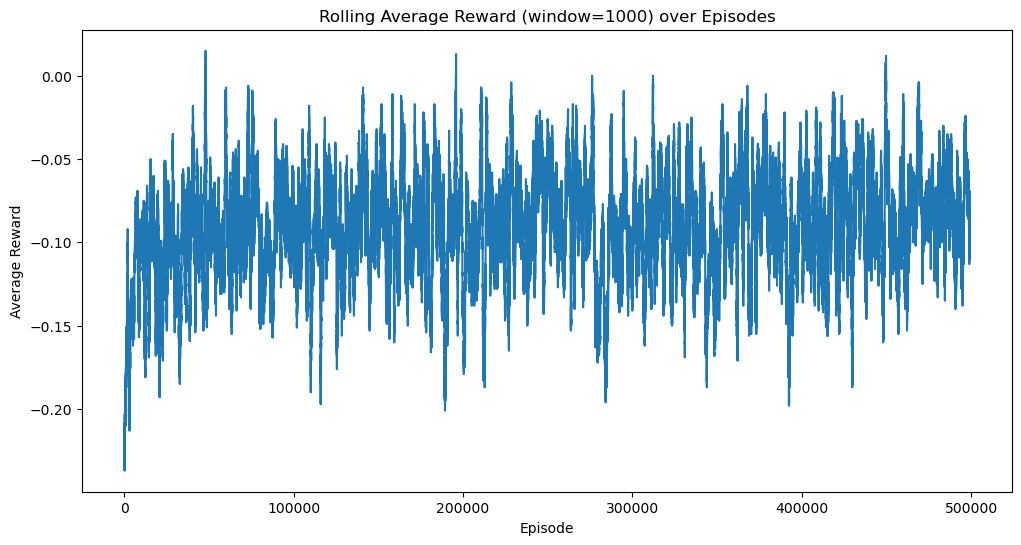

In [40]:
# Plot rolling average of rewards
window = 1000
rolling_avg = np.convolve(mc_rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12,6))
plt.plot(rolling_avg)
plt.title(f"Rolling Average Reward (window={window}) over Episodes")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.show()

### Monte Carlo Learning Curve Summary

The plot above shows the rolling average reward (window = 1000 episodes) over 500,000 training episodes using the Monte Carlo Control method. Despite some fluctuations due to the stochastic nature of the Blackjack environment and ε-greedy exploration, the agent demonstrates a gradual improvement in performance. Over time, the average reward stabilizes around **-0.06**, indicating that the learned policy performs reasonably well, though the environment remains slightly biased against the player.

Extract the Policy and Value Function

In [41]:
def extract_policy(Q):
    policy = {}
    for state, actions in Q.items():
        policy[state] = np.argmax(actions)
    return policy

def compute_value_function(Q):
    V = defaultdict(float)
    for state, actions in Q.items():
        V[state] = np.max(actions)
    return V

policy_mc = extract_policy(Q_mc)
V_mc = compute_value_function(Q_mc)

Plot Value Function (Heatmaps)

In [42]:
def plot_value_function(V, usable_ace=True):
    value_grid = np.zeros((10, 10))
    for player_sum in range(12, 22):
        for dealer_card in range(1, 11):
            state = (player_sum, dealer_card, usable_ace)
            value_grid[player_sum - 12, dealer_card - 1] = V.get(state, 0)

    plt.figure(figsize=(10, 8))
    sns.heatmap(value_grid, annot=True, cmap="coolwarm", xticklabels=range(1, 11), yticklabels=range(12, 22))
    plt.xlabel("Dealer Showing")
    plt.ylabel("Player Sum")
    plt.title(f"Value Function - {'Usable Ace' if usable_ace else 'No Usable Ace'}")
    plt.show()

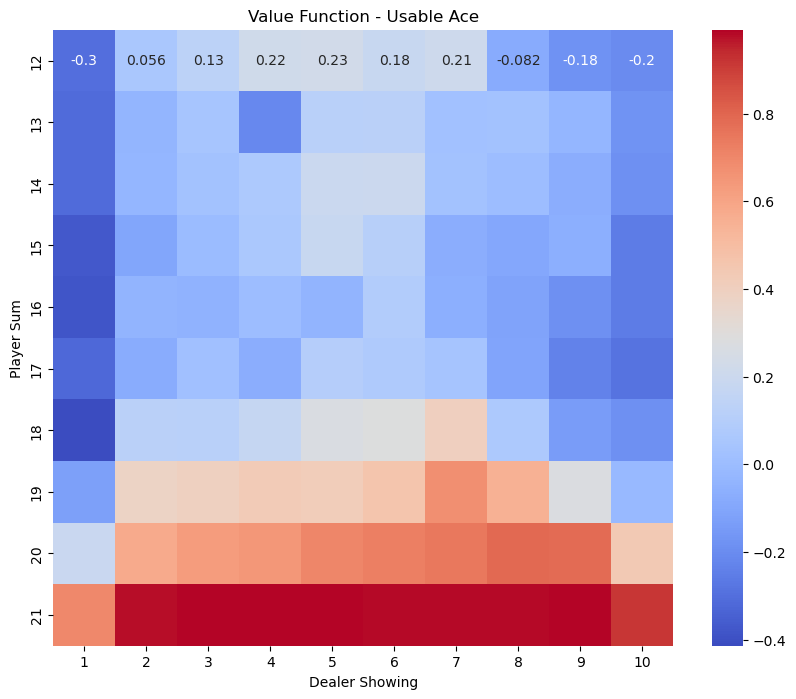

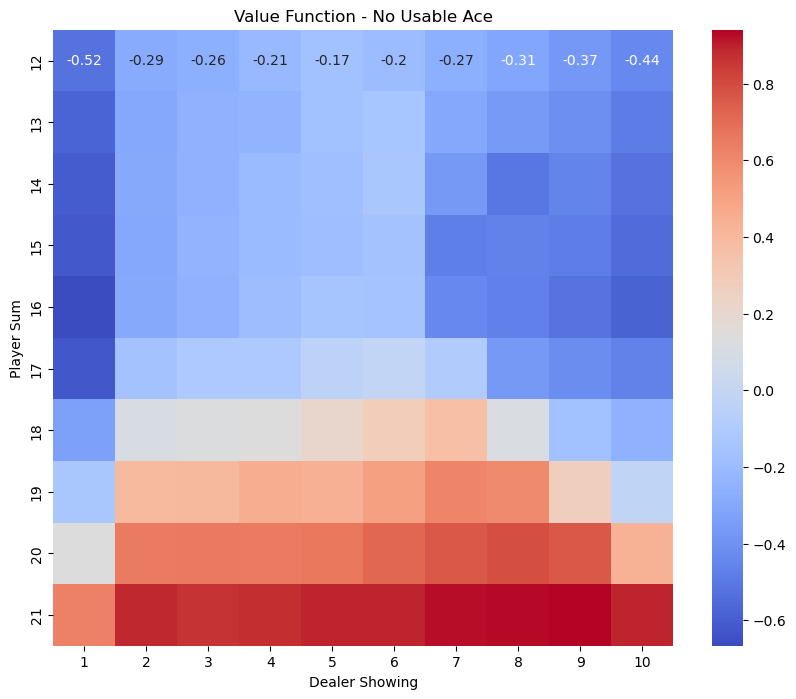

In [43]:
# Plot both versions
plot_value_function(V_mc, usable_ace=True)
plot_value_function(V_mc, usable_ace=False)

The heatmaps show the estimated state value functions (V(s) = max_a Q(s, a)) learned by the Monte Carlo agent, split by whether the player has a usable ace or not:
The presence of a usable ace generally leads to higher expected returns, confirming the strategic value of flexible Aces in Blackjack.

Plot Learning Curve

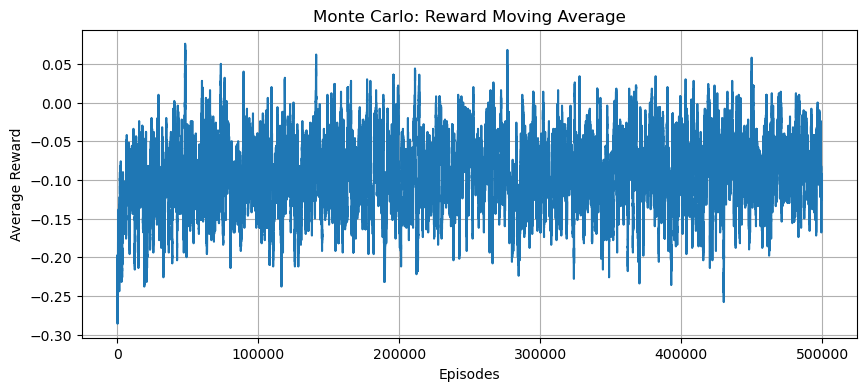

In [44]:
rolling_length = 500
plt.figure(figsize=(10, 4))
plt.title("Monte Carlo: Reward Moving Average")
reward_moving_avg = (
    np.convolve(mc_rewards, np.ones(rolling_length), mode="valid") / rolling_length
)
plt.plot(reward_moving_avg)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.grid()
plt.show()

## 4. Comparison between Q-Learning and Monte Carlo

In this section, we compare the performance of **Monte Carlo Control** and **Q-Learning**, applied to the `Blackjack-v1` environment from OpenAI Gym. Both agents were trained for 500,000 episodes using ε-greedy exploration strategies.

The comparison focuses on the average reward obtained in the final episodes of training, which reflects the quality of the learned policies.

| Algorithm           | Average Reward (Last 1000 Episodes) |
|---------------------|--------------------------------------|
| Monte Carlo Control | -0.07                                |
| Q-Learning          | -0.132                               |


Q-Learning average reward (last 1000 episodes): -0.1320
Monte Carlo average reward (last 1000 episodes): -0.0980


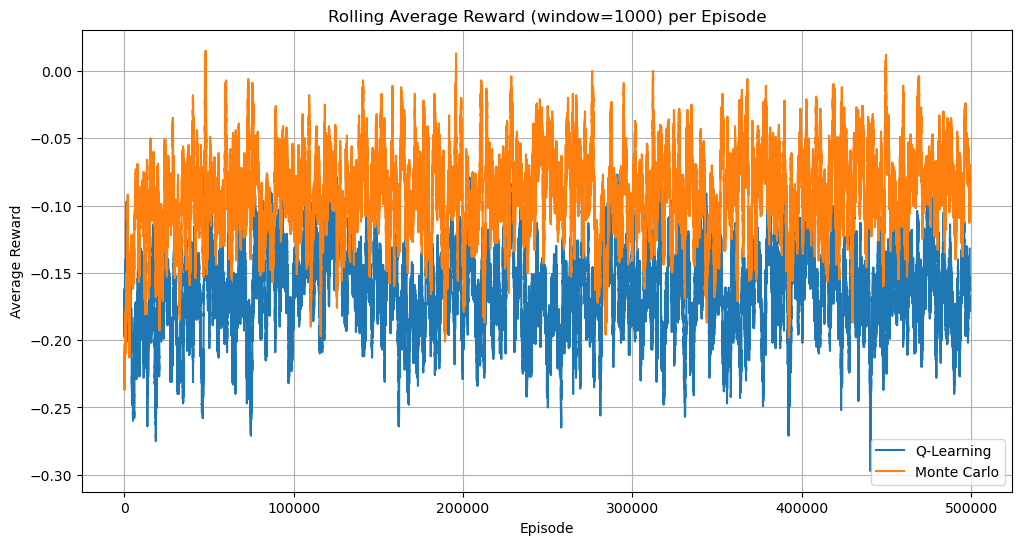

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Compute average reward over last 1000 episodes for both agents
q_avg_reward = np.mean(returns[-1000:])
mc_avg_reward = np.mean(mc_rewards[-1000:])

print(f"Q-Learning average reward (last 1000 episodes): {q_avg_reward:.4f}")
print(f"Monte Carlo average reward (last 1000 episodes): {mc_avg_reward:.4f}")

# Plot rolling average reward with window size 1000 for smoother visualization
window = 1000
q_rolling_avg = np.convolve(returns, np.ones(window)/window, mode='valid')
mc_rolling_avg = np.convolve(mc_rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12,6))
plt.plot(q_rolling_avg, label='Q-Learning')
plt.plot(mc_rolling_avg, label='Monte Carlo')
plt.title('Rolling Average Reward (window=1000) per Episode')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True)
plt.show()


The results indicate that **Monte Carlo Control** outperformed **Q-Learning** in terms of average reward in the final phase of training. This suggests that Monte Carlo Control learned a more effective policy in this environment.

While Q-Learning typically converges faster due to its bootstrapping nature and updates after each step, it may be less stable in highly stochastic, episodic environments like Blackjack. In contrast, Monte Carlo methods benefit from complete episode returns, making them better suited for episodic tasks with clearly defined episode boundaries.

In conclusion, while both methods successfully learned policies in the Blackjack environment, **Monte Carlo Control** achieved better final performance. Its ability to utilize full-episode returns gave it an advantage in this task, despite potentially slower initial learning. Therefore, for episodic environments with high variance like Blackjack, Monte Carlo methods can be more suitable than TD-based approaches such as Q-Learning.


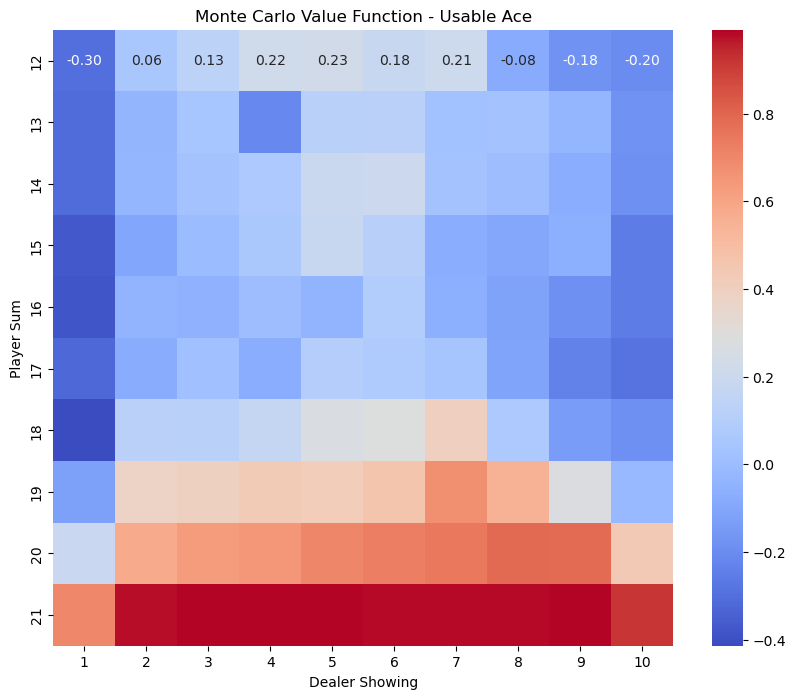

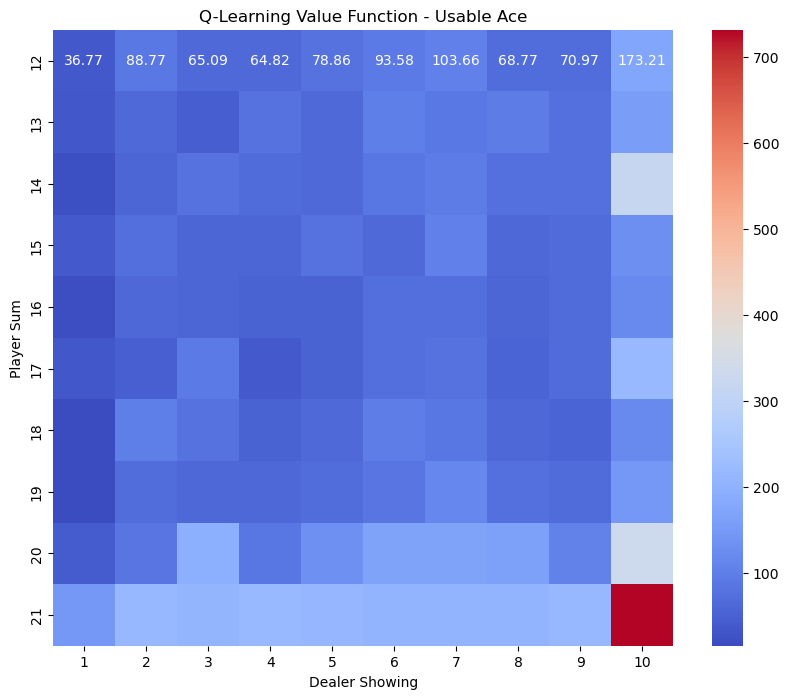

In [51]:
def plot_value_function(V, title, usable_ace=True):
    value_grid = np.zeros((10, 10))
    for player_sum in range(12, 22):  # player sum 12-21 (inclusive)
        for dealer_card in range(1, 11):  # dealer showing 1-10
            state = (player_sum, dealer_card, usable_ace)
            value_grid[player_sum - 12, dealer_card - 1] = V.get(state, 0)

    plt.figure(figsize=(10, 8))
    sns.heatmap(value_grid, annot=True, fmt=".2f", cmap="coolwarm",
                xticklabels=range(1, 11), yticklabels=range(12, 22))
    plt.xlabel("Dealer Showing")
    plt.ylabel("Player Sum")
    plt.title(f"{title} - {'Usable Ace' if usable_ace else 'No Usable Ace'}")
    plt.show()

# Use your value functions:
plot_value_function(V_mc, title="Monte Carlo Value Function", usable_ace=True)
plot_value_function(V, title="Q-Learning Value Function", usable_ace=True)
